## Bayesian OC4

[Previously](https://madhatter106.github.io/DataScienceCorner/posts/bayesian-approach-to-chlorophyll-estimation-from-satellite-remote-sensing/), I implemented the bayesian version of the OC4 empirical chlorophyll algorithm, where the input consists of the log of the ratio of the maximum of three blue bands to a green band.
Here I will focus on the OC4 algorithm, part of the OCx family of empirical algorithms, which are  generally expressed as follows.
$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{4}a_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

However, some diagnostics of the model results suggested that a $4^{th}$ order polynomial may be too complex.
This post is about *model comparison* , which I illustrate by pitting [last post's](https://madhatter106.github.io/DataScienceCorner/posts/bayesian-approach-to-chlorophyll-estimation-from-satellite-remote-sensing/) model against a simpler $3^{rd}$ order polynomial regression in an attempt. Some of the concepts I apply include posterior predictive checks on training as well as out-of-sample data, information criteria measures, and bayes factor.
<!--TEASER_END-->

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
from scipy.stats import norm
import matplotlib.pyplot as pl
import pymc3 as pm
import pandas as pd
import seaborn as sb
import pickle
from sklearn.metrics import mean_squared_error, r2_score
from theano import shared

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
## HELPER FUNCTIONS
# ---------------------------------------------------

def FitPoly(X,y, order=4, lin=False):
    """
    Numpy regression. Returns coeffs.
    kwargs:
        lin: specifies whether data is log transformed. Data is log transformed if not."""
    if lin:
        X = np.log10(X)
        y = np.log10(y)
    coeffs = np.polyfit(X,y,deg=order)
    return coeffs[::-1]

def GetPPC(data, mcChain, pmModel, varname, hierarchical_idx=None):
    ppcTrain = pm.sample_ppc(mcChain, samples=1000, model=pmModel)
    # sample posterior predictive check for 50% and 95% density interval
    idx = np.argsort(data)
    sig0 = pm.hpd(ppcTrain[varname], alpha=0.5)[idx] 
    sig1 = pm.hpd(ppcTrain[varname], alpha=0.05)[idx]
    return sig0, sig1

def PlotPPC(data, chlObs, sig0, sig1, bayesCoeffs, oc4V6Coeffs=[], myOLS_coeffs=[],
           title='PPC', ax=None, legendOn=True, xlblOn=True, ylblOn=True):
    idx = np.argsort(data)
    data_ord = data[idx]
    dataMock = np.linspace(data.min(),data.max(),100)
    chlBayes=0
    for i,coeff in enumerate(bayesCoeffs):
        chlBayes += coeff * dataMock**i
    if not ax:
        f,ax = pl.subplots(figsize=(16,10))
    ax.fill_between(data_ord, sig0[:,0], sig0[:,1], color='k', alpha=1, label='50% HPD.')
    ax.fill_between(data_ord, sig1[:,0], sig1[:,1], color='darkgray', alpha=0.5, label='95% HDP')
    ax.plot(data, chlObs, 'ko', alpha=0.5, markeredgecolor='k',  label='Observation')
    if len(oc4V6Coeffs)>0:
        oc4V6Modl=0
        for i, coef in enumerate(oc4V6Coeffs):
            oc4V6Modl += coef * dataMock**i
        ax.plot(dataMock, oc4V6Modl,'r', linewidth=3, linestyle='--', label='OC4v6')
    if len(myOLS_coeffs)>0:
        olsMdl=0
        for i,coeff in enumerate(myOLS_coeffs[::-1]):
            olsMdl+= coeff * dataMock**i
        pl.plot(dataMock, olsMdl,'m', linewidth=5, label='OLS')
    ax.plot(dataMock, chlBayes,'b', linewidth=2, label='Bayesian Regression Mean')
    if xlblOn:
        ax.set_xlabel(r'$log_{10}\frac{max(Rrs\left(\lambda_{blue}\right))}{Rrs\left(\lambda_{green}\right)}$', fontsize=20)
    if ylblOn:
        ax.set_ylabel(r'$log_{10}\left(chlor_a\right)$', fontsize=20);
    if legendOn:
        ax.legend(fontsize=14);
    ax.set_title(title);
    return pl.gca()

In [3]:
dfNomadV2 = pd.read_pickle('./bayesianChl_DATA/NOMADV2SWFClean.pkl')
dfNomadV2.columns

Index(['id', 'depth', 'rrs411', 'rrs443', 'rrs489', 'rrs510', 'rrs555',
       'rrs670', 'hplc_chl', 'fluo_chl', 'chl_all'],
      dtype='object')

In [4]:
dfNomadV2['chl_type'] = np.where(dfNomadV2.hplc_chl.isnull(),'fluor','hplc')
dfNomadV2.chl_type = dfNomadV2.chl_type.astype('category')

Note the apparent strong collinearity among the reflectances. Also the data appears mostly lognormally distributed (*cf. also Campbell et al, 1995*). I'll next create a maxBlue column, and Blue2GreenRatio column. Then I'll log tranform the blue2green ratio and the chlorophyll data put that in a new dataframe. I'll keep the id column in case I need to determine the origin of a particular observation.

In [5]:
dfNomadV2.columns

Index(['id', 'depth', 'rrs411', 'rrs443', 'rrs489', 'rrs510', 'rrs555',
       'rrs670', 'hplc_chl', 'fluo_chl', 'chl_all', 'chl_type'],
      dtype='object')

In [6]:
dfNomadV2['maxBlue'] = dfNomadV2.loc[:, ['rrs443','rrs489','rrs510']].max(axis=1)
dfNomadV2['blue2green'] = dfNomadV2.maxBlue / dfNomadV2.rrs555
dfLogOCx = pd.DataFrame(columns=['id','mxBl2Gr', 'chl',])
dfLogOCx['id'] = dfNomadV2.id
dfLogOCx['mxBl2Gr'] = np.log10(dfNomadV2.blue2green.values)
dfLogOCx['chl'] = np.log10(dfNomadV2.chl_all.values)
# chl_type codes, 0: fluo, 1: hplc
dfLogOCx['chl_type'] = dfNomadV2.chl_type.cat.codes

And let's inspect the data again

In [7]:
dfLogOCx.info(),dfLogOCx.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 4458
Data columns (total 4 columns):
id          1016 non-null int32
mxBl2Gr     1016 non-null float64
chl         1016 non-null float64
chl_type    1016 non-null int8
dtypes: float64(2), int32(1), int8(1)
memory usage: 28.8 KB


(None,                 id      mxBl2Gr          chl     chl_type
 count  1016.000000  1016.000000  1016.000000  1016.000000
 mean   4598.373031     0.117382     0.089204     0.410433
 std    2318.827769     0.287944     0.702093     0.492155
 min    1441.000000    -0.353183    -1.769551     0.000000
 25%    2118.750000    -0.087723    -0.456596     0.000000
 50%    3702.500000     0.021409     0.068000     0.000000
 75%    7036.250000     0.255020     0.574263     1.000000
 max    7831.000000     0.982648     1.891341     1.000000)

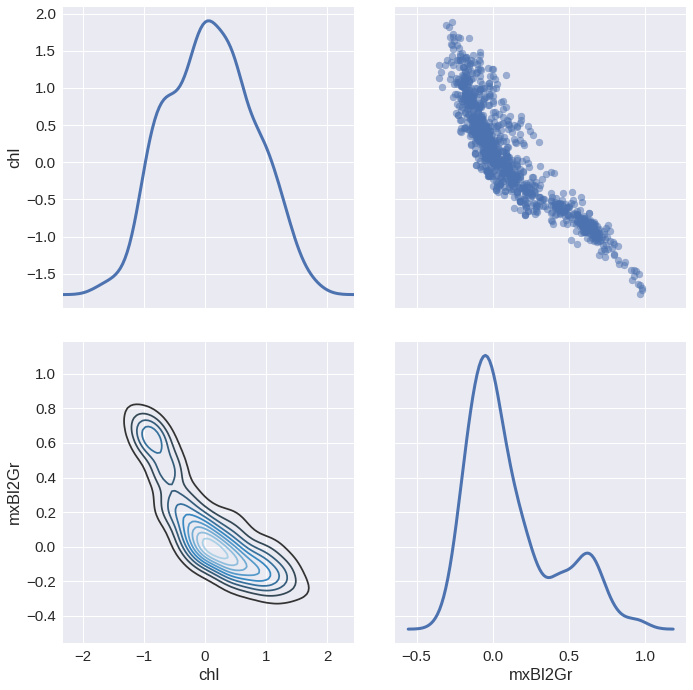

In [16]:
sb.set(font_scale=1.5)
g = sb.PairGrid(dfLogOCx, vars=['chl', 'mxBl2Gr'], size=5, diag_sharey=False);
g = g.map_upper(pl.scatter,alpha=0.5)
g = g.map_diag(sb.kdeplot, lw=3)
g = g.map_lower(sb.kdeplot, cmap="Blues_d");
g.savefig('./bayesianChl_stuff/dataOverview.png', dpi=300, format='png')

I'll compute OLS coefficients for polynomials of degree 3 and 4 for reference. Note that I define X_train, y_train here as well, this is in contrast to the testing data that I will later assign to X_test and y_test

In [9]:
X_train = dfLogOCx.mxBl2Gr.values
y_train = dfLogOCx.chl.values
ols3 = FitPoly(X_train, y_train, order=3, lin=False)
ols4 = FitPoly(X_train, y_train, order=4, lin=False)

### Bayesian linear regression.
For now, I am simply going to assume I'm still looking for a $4^{th}$ order polynomial. Model comparison will be the subject of a subsequent post.
First I have to specify some priors around the coefficients. I'll assume weakly informative gaussian priors. Before deciding an appropriate distribution for the likelihood, I will check the normality of the  data by way of a normality plot, as well as a comparison between the cummulative distribution function (CDF) of the data and a normal standard distribution.

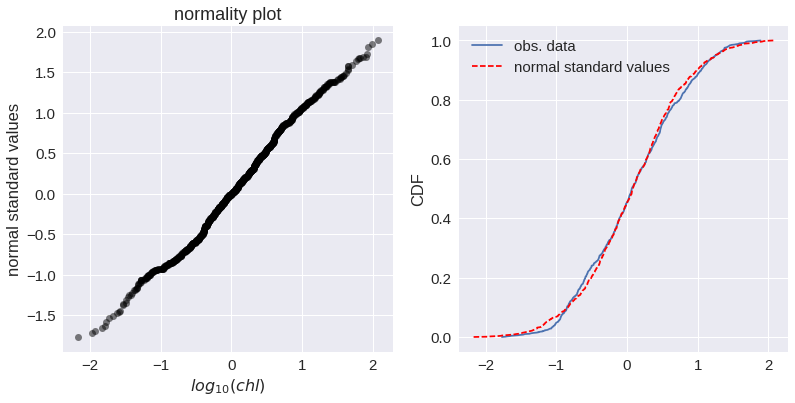

In [10]:
normData = norm.rvs(y_train.mean() ,y_train.std(),
                    size=y_train.size)
normDataSort = np.sort(normData)
logChlSort = np.sort(y_train)
f,ax = pl.subplots(ncols=2,figsize=(13,6))
lbl = r'$log_{10}(chl)$'
ax[0].plot(normDataSort, logChlSort,'ko', alpha=0.5)
ax[0].set_xlabel('%s' %lbl, fontsize=16)
ax[0].set_ylabel('normal standard values');
ax[0].set_title('normality plot')
ax[1].plot(logChlSort, np.linspace(0,1,logChlSort.size), label='obs. data')
ax[1].plot(normDataSort,np.linspace(0,1,normDataSort.size),'r--', 
          label='normal standard values')
ax[1].set_ylabel('CDF')
ax[1].legend(loc='best');

### Bayesian Regression Models
    Model two polynomial regression
        * Order 4 -- O(4)
        * Order 3 -- O(3) 
        * Diagram: 

<img src="./bayesianChl_stuff/ocx_34.png", width=650, height=600>

### Order 4 Polynomial
***

In [10]:
with pm.Model() as OC4_prior:
    a0_4 = pm.Normal('a0_4', mu=0, sd=10)
    a1_4 = pm.Normal('a1_4', mu=0, sd=10)
    a2_4 = pm.Normal('a2_4', mu=0, sd=10)
    a3_4 = pm.Normal('a3_4', mu=0, sd=10)
    a4_4 = pm.Normal('a4_4', mu=0, sd=10)
    epsilon_4 = pm.Uniform('epsilon_4', lower=0, upper=10)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_prior=pm.sample(10000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 17.493913
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


100%|██████████| 10000/10000 [00:02<00:00, 4031.88it/s]


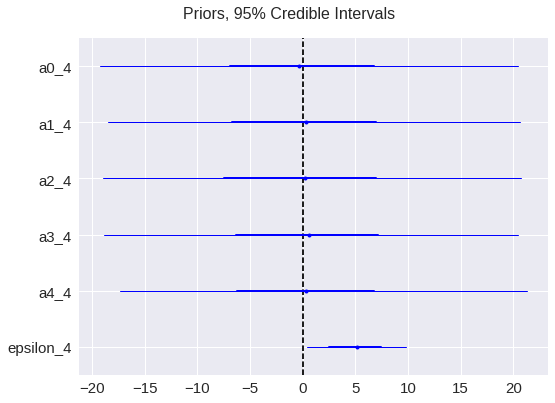

In [11]:
pm.forestplot(trace_prior, varnames=['a%d_4' %i for i in range(5)] 
              + ['epsilon_4'], main=False)
f = pl.gcf()
f.suptitle('Priors, 95% Credible Intervals', fontsize=16)
f.savefig('./bayesianChl_stuff/o4_prior.png', dpi=300, format='png')

In [11]:
X_Shrd = shared(X_train)
with pm.Model() as OC4_ord4:
    a0_4 = pm.Normal('a0_4', mu=0, sd=10)
    a1_4 = pm.Normal('a1_4', mu=0, sd=10)
    a2_4 = pm.Normal('a2_4', mu=0, sd=10)
    a3_4 = pm.Normal('a3_4', mu=0, sd=10)
    a4_4 = pm.Normal('a4_4', mu=0, sd=10)
    epsilon_4 = pm.Uniform('epsilon_4', lower=0, upper=10)
    mu_4 = a0_4 + a1_4 * X_Shrd + a2_4 * X_Shrd**2 + a3_4 * X_Shrd**3 + a4_4 * X_Shrd**4
    chlPred_4 = pm.Normal('chlPred_4', mu=mu_4, sd=epsilon_4, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ord4 = pm.sample(10000, step=step, start=start)

Applied interval-transform to epsilon_4 and added transformed epsilon_4_interval_ to model.
100%|██████████| 10000/10000 [00:35<00:00, 280.44it/s]


In [12]:
with pm.Model() as OC4_ord3:
    a0_3 = pm.Normal('a0_3', mu=0, sd=10)
    a1_3 = pm.Normal('a1_3', mu=0, sd=10)
    a2_3 = pm.Normal('a2_3', mu=0, sd=10)
    a3_3 = pm.Normal('a3_3', mu=0, sd=10)
    epsilon_3 = pm.Uniform('epsilon_3', lower=0, upper=10)
    mu_3 = a0_3 + a1_3 * X_Shrd + a2_3 * X_Shrd**2 + a3_3 * X_Shrd**3
    chlPred_3 = pm.Normal('chlPred_3', mu=mu_3, sd=epsilon_3, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ord3 = pm.sample(10000, step=step, start=start)

Applied interval-transform to epsilon_3 and added transformed epsilon_3_interval_ to model.
100%|██████████| 10000/10000 [00:13<00:00, 715.76it/s]


In [13]:
with pm.Model() as OC4_ord3_robust:
    a0_3r = pm.Normal('a0_3r', mu=0, sd=10)
    a1_3r = pm.Normal('a1_3r', mu=0, sd=10)
    a2_3r = pm.Normal('a2_3r', mu=0, sd=10)
    a3_3r = pm.Normal('a3_3r', mu=0, sd=10)
    epsilon_3r = pm.HalfCauchy('epsilon_3r', 5)
    mu_3r = a0_3r + a1_3r * X_Shrd + a2_3r * X_Shrd**2 + a3_3r * X_Shrd**3
    nu = pm.Deterministic('nu',pm.Exponential('nu_', 3) + 1)
    chlPred_3r = pm.StudentT('chlPred_3r', mu=mu_3r, sd=epsilon_3r, nu=nu, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ord3_rob = pm.sample(10000, step=step, start=start)

Applied log-transform to epsilon_3r and added transformed epsilon_3r_log_ to model.
Applied log-transform to nu_ and added transformed nu__log_ to model.
100%|██████████| 10000/10000 [00:38<00:00, 258.48it/s]


In [14]:
# remove some burn-in
chain_ord4 = trace_ord4[1000:]
chain_ord3 = trace_ord3[1000:]
chain_o3r = trace_ord3_rob[1000:]
varnames_o4=['a%d_4' %d for d in range(5)]
varnames_o3=['a%d_3' %d for d in range(4)]
varnames_o3r = ['a%d_3r' %i for i in range(4)]

### O(4) Results

#### Posterior Marginals

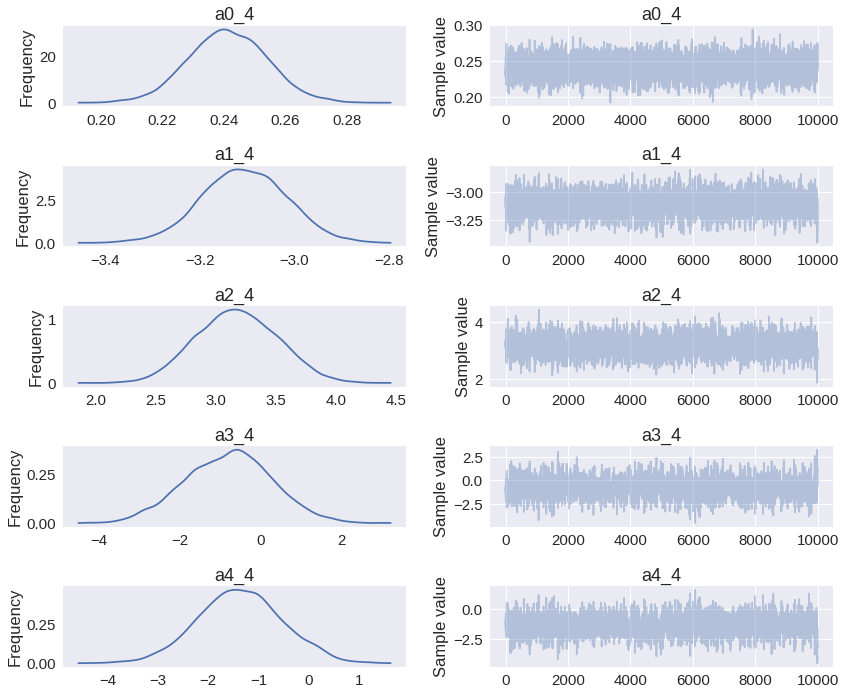

In [17]:
pm.traceplot(trace_ord4, varnames_o4, figsize=(12, 10));

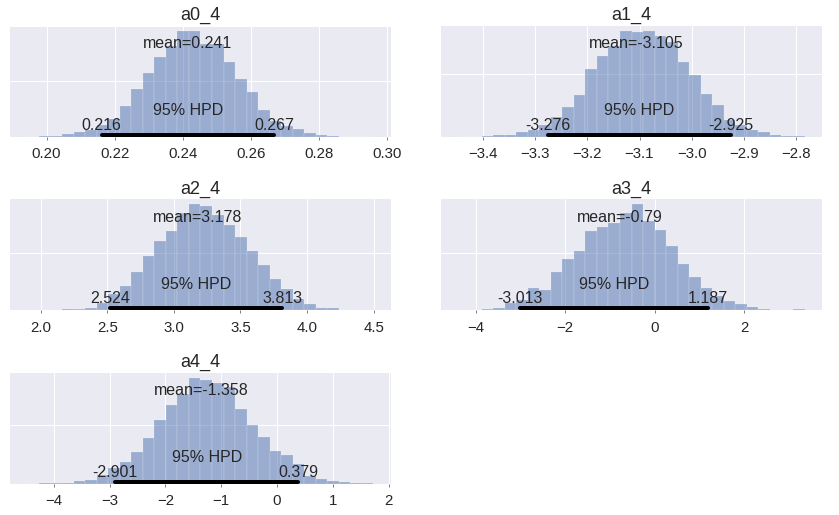

In [18]:
pm.plot_posterior(chain_ord4, varnames=varnames_o4, alpha=0.5);
f_pos = pl.gcf()
f_pos.savefig('./bayesianChl_stuff/o4_postPlot.png', dpi=300, format='png')

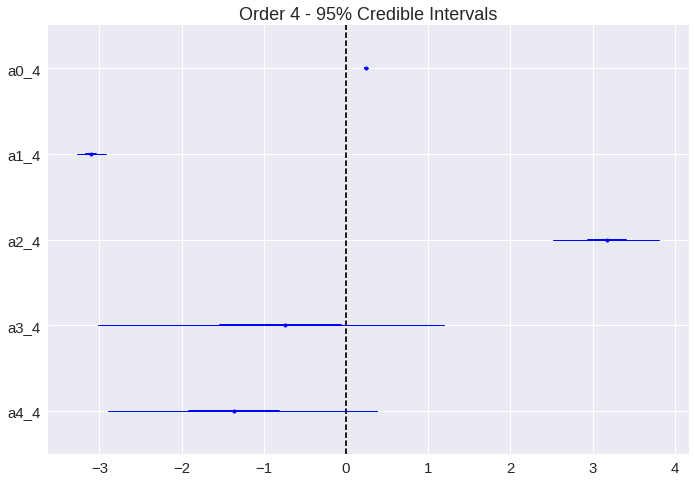

In [20]:
# Order 4
gs = pm.forestplot(chain_ord4,varnames=['a%d_4' %i for i in range(5)] , main='Order 4 - 95% Credible Intervals')
f = pl.gcf()
f.set_size_inches(10,7)
f.savefig('./bayesianChl_stuff/o4_foresplot.png', dpi=300, format='png')

#### Parameter Interaction

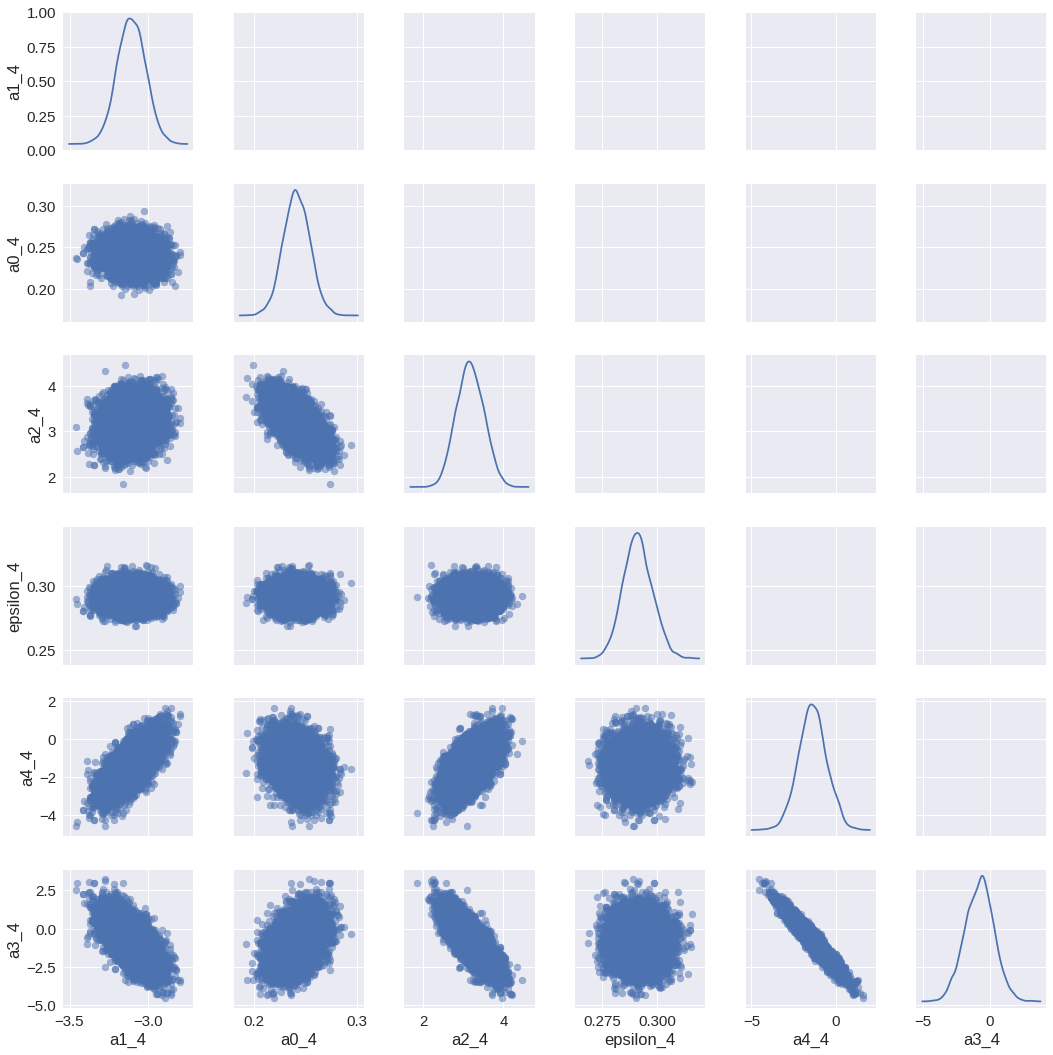

In [19]:
df_trace = pm.trace_to_dataframe(chain_ord4)
df_trace.rename(columns={'a%d_3'%i: 'a%d'%i for i in range(4)})
g = sb.PairGrid(df_trace, diag_sharey=False)
g = g.map_diag(sb.kdeplot)
g = g.map_lower(pl.scatter, alpha=0.5)
g.savefig('./bayesianChl_stuff/o4_pairgrid.png', dpi=300, format='png')

### O(3) Results

#### Posterior Marginals

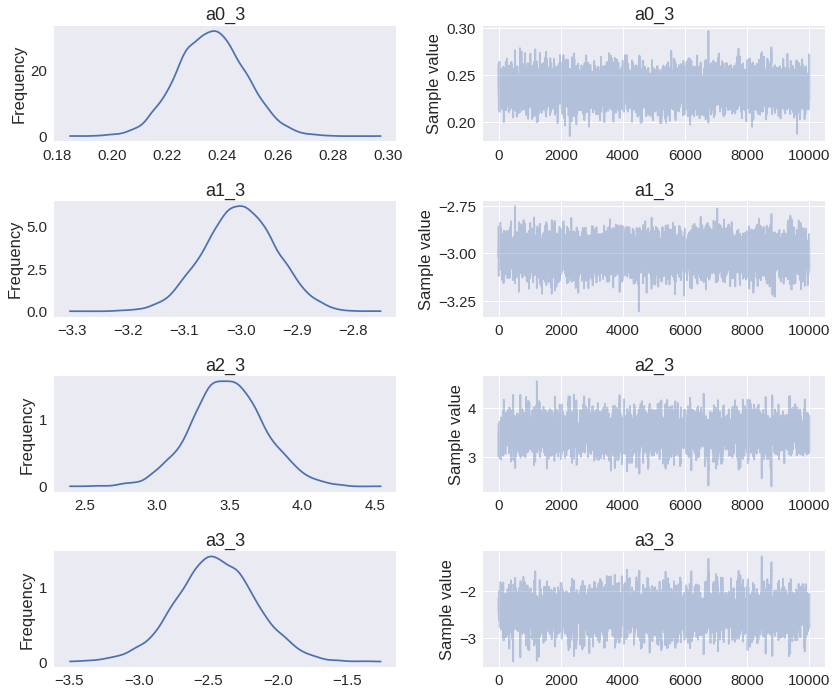

In [21]:
pm.traceplot(trace_ord3, varnames=varnames_o3, figsize=(12,10));

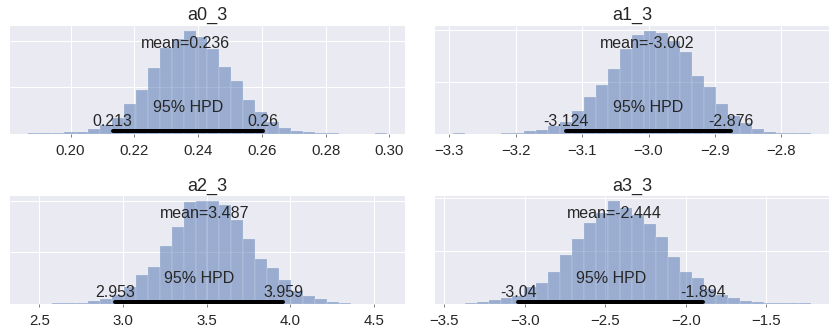

In [22]:
pm.plot_posterior(chain_ord3, varnames=varnames_o3, alpha=0.5);
fpp3 = pl.gcf()
fpp3.savefig('./bayesianChl_stuff/o3_postPlot.png')

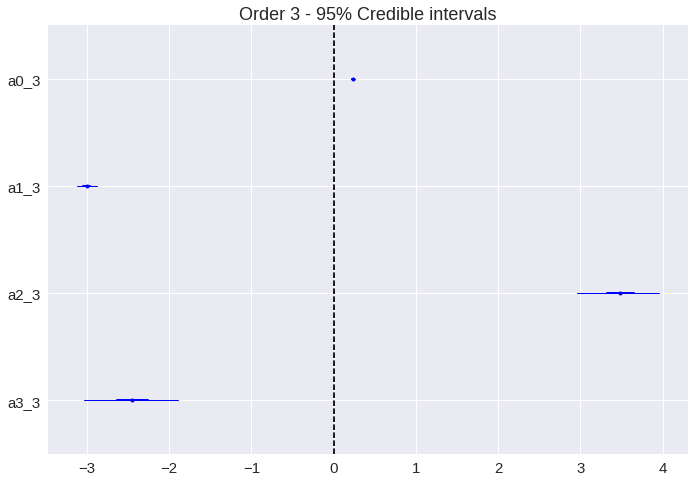

In [27]:
pm.forestplot(chain_ord3,varnames=['a%d_3' %i for i in range(4)], main='Order 3 - 95% Credible intervals');
ff3 = pl.gcf()
ff3.set_size_inches(10,7)
ff3.savefig('./bayesianChl_stuff/o3_foresplot.png', dpi=300, format='png')

#### Parameter Interaction

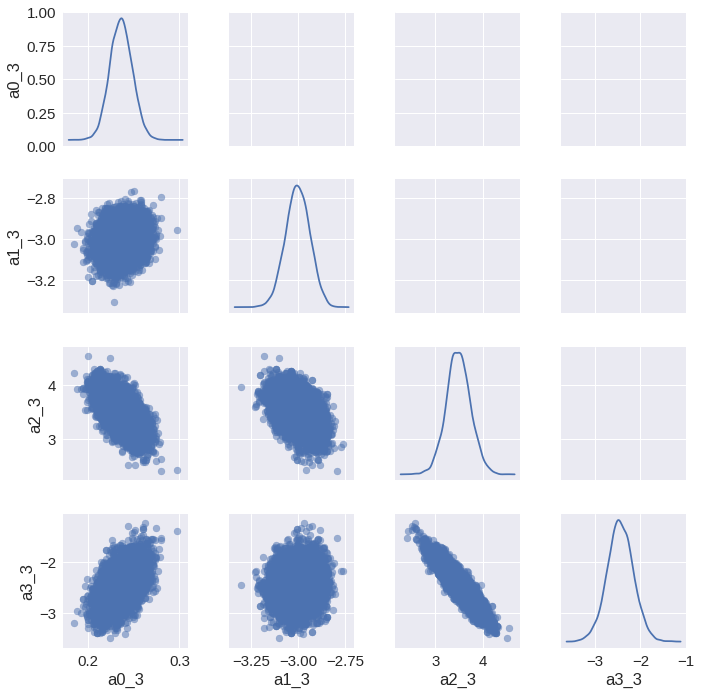

In [26]:
df_trace = pm.trace_to_dataframe(chain_ord3)
df_trace.rename(columns={'a%d_3'%i: 'a%d'%i for i in range(4)})
g = sb.PairGrid(df_trace, vars=['a%d_3' %i for i in range(4)], diag_sharey=False)
g = g.map_diag(sb.kdeplot)
g = g.map_lower(pl.scatter, alpha=0.5)
g.savefig('./bayesianChl_stuff/o3_pairgrid.png', dpi=300, format='png')

#### Comparing Order 3 and Order 4 Polynomial Regression Outputs

Note how in the case of the order 4 polynomial regression, a3 and a4 straddle the '0' line with rather wide HDI's. This is not the case with any of the order 3 polynomial regression. 

### Model Comparisons:
The diagnostics I will use here are
* posterior predictive checks on in-sample data
* information criteria; including
    * deviance information criterion
    * widely available information criterion
* posterior predictive checks on out-of-sample data

#### Posterior Predictive Checks on in-sample data

In [29]:
sig0_ord4, sig1_ord4 = GetPPC(data=X_train, mcChain=chain_ord4, pmModel=OC4_ord4, varname='chlPred_4')
bayesCoeffs_ord4 = [chain_ord4['a%d_4' %i].mean() for i in range(5)]
sig0_ord3, sig1_ord3 = GetPPC(data=X_train, mcChain=chain_ord3, pmModel=OC4_ord3, varname='chlPred_3')
bayesCoeffs_ord3 = [chain_ord3['a%d_3' %i].mean() for i in range(4)]
sig0_ord3r, sig1_ord3r = GetPPC(data=X_train, mcChain=chain_o3r, pmModel=OC4_ord3_robust, varname='chlPred_3r')
bayesCoeffs_ord3r = [chain_o3r['a%d_3r' %i].mean() for i in range(4)]

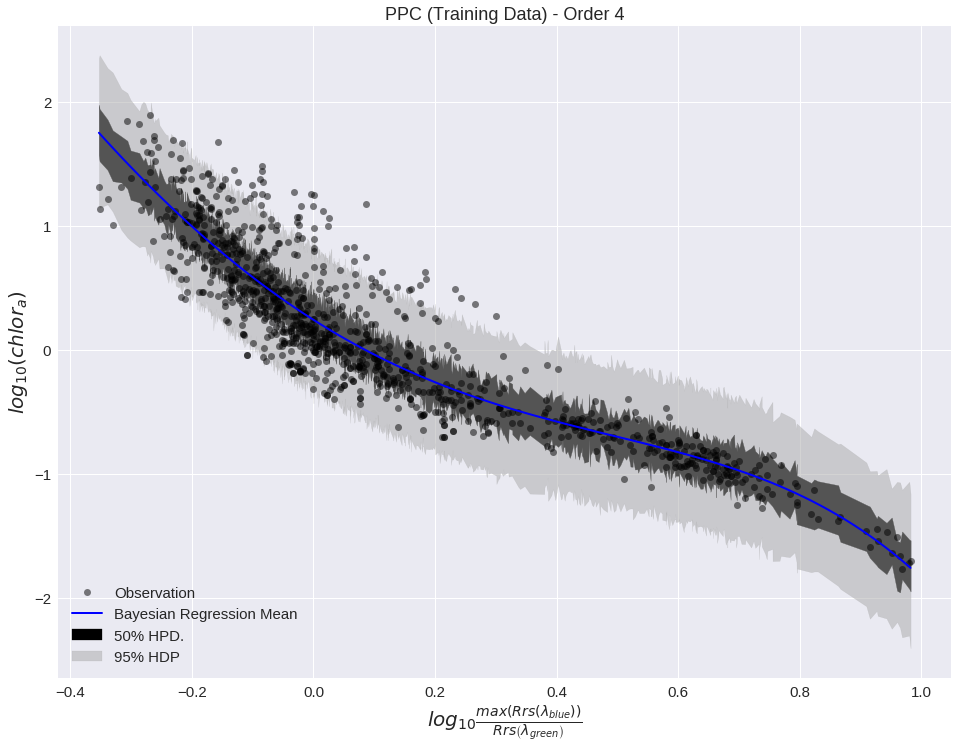

In [34]:
f, ax = pl.subplots(figsize=(16, 12))
_ = PlotPPC(X_train, y_train, sig0_ord4, sig1_ord4, bayesCoeffs_ord4,ax=ax,
            title='PPC (Training Data) - Order 4', legendOn=False)
ax.legend(loc=3)
f.savefig('./bayesianChl_stuff/ppcO4.png', dpi=300, format='png')

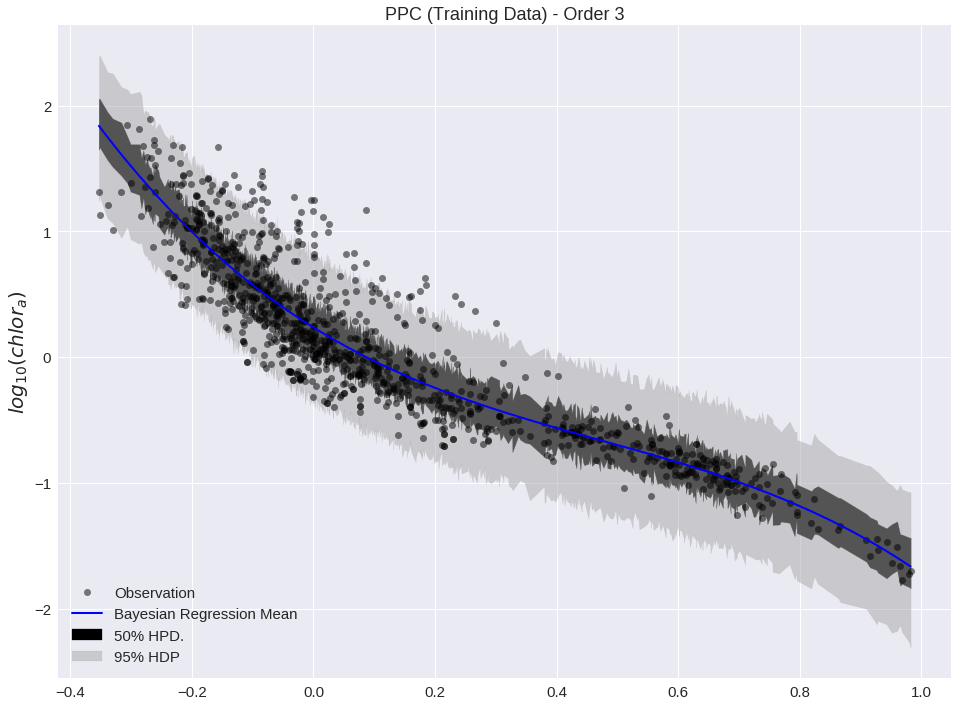

In [33]:
f, ax = pl.subplots(figsize=(16, 12))
_ = PlotPPC(X_train, y_train, sig0_ord3, sig1_ord3, bayesCoeffs_ord3,ax=ax,
            title='PPC (Training Data) - Order 3', xlblOn=False)
ax.legend(loc=3)
f.savefig('./bayesianChl_stuff/ppcO3.png', dpi=300, format='png')

#### 
#TODO: include diagram

#### Computing Bayes Factors: nested sampling
#TODO: include diagram

In [ ]:
with pm.Model() as OC4_BF:
    # Hyperpriors
    mu_a0 = pm.Normal('mu_a0', mu=0, sd=10)
    sd_a0 = pm.HalfNormal("sd_a0", sd=20)
    mu_a1 = pm.Normal('mu_a1', mu=0, sd=10)
    sd_a1= pm.HalfNormal('sd_a1', sd=20)
    mu_a2 = pm.Normal('mu_a2', mu=0, sd=10)
    sd_a2 = pm.HalfNormal('sd_a2', sd=20)
    mu_a3 = pm.Normal('mu_a3', mu=0, sd=10)
    sd_a3 = pm.HalfNormal("sd_a3", sd=20)
    # priors
    a0_bf = pm.Normal('a0_bf', mu=mu_a0, sd=sd_a0, shape=2)
    a1_bf = pm.Normal('a1_bf', mu=mu_a1, sd=sd_a1, shape=2)
    a2_bf = pm.Normal('a2_bf', mu=mu_a2, sd=sd_a2, shape=2)
    a3_bf = pm.Normal('a3_bf', mu=mu_a3, sd=sd_a3, shape=2)
    a4_bf = pm.Normal('a4_bf', mu=0, sd=10)
    epsilon_bf = pm.Uniform('epsilon_bf', lower=0, upper=10)
    # TODO: Add pseudo-priors for bf.
    # model priors
    pO3 = 0.5
    pO4 = 0.5
    # setting up nested sampling
    p = np.array([pO3, pO4])
    model_index = pm.Categorical('model_index', p=p)
    mu_3 = a0_bf[0] + a1_bf[0] * X_Shrd + a2_bf[0] * X_Shrd**2 + a3_bf[0] * X_Shrd**3 
    mu_4 = a0_bf[1] + a1_bf[1] * X_Shrd + a2_bf[1] * X_Shrd**2 + a3_bf[1] * X_Shrd**3 + a4_bf * X_Shrd**4
    mu_bf = pm.math.switch(pm.math.eq(model_index, 0), mu_3, mu_4)
    # likelihood
    chlPred_bf = pm.Normal('chlPred_bf', mu=mu_bf, sd=epsilon_bf, observed=y_train)
    # mcmc sampling
    start = pm.find_MAP()
    step1 = pm.ElemwiseCategorical(vars=[model_index], values=[0,1])
    step2 = pm.NUTS(scaling=start)
    trace_bf = pm.sample(10000, step=[step1, step2], start=start)

In [ ]:
chain_bf = trace_bf[1000:]
pm.traceplot(chain_bf);

In [ ]:
pm.forestplot(chain_bf, varnames=['a%d_bf' %i for i in range(5)] + ['a%d_bf_3' %j for j in range(4)])

In [ ]:
pMO4 = chain_bf['model_index'].mean()
pMO3 = 1 - pMO4
BF = (pMO3/pMO4)*(p[1]/p[0])
print(BF)

Typically for a score >1, the evidence is in favor of the model in the numerator. 
[Kass and Raftery (1995)](http://links.jstor.org/sici?sici=0162-1459%28199506%2990%3A430%3C773%3ABF%3E2.0.CO%3B2-8), rank Bayes Factor Scores as:
    * 1-3:    Not worth more than a bare mention
    * 3-20:   Positive
    * 20-150: Strong
    * >150:   Very strong

#### Deviance Information Criteria (DIC)
* what it is
* how it's calculated
* what it tells us

In [35]:
dic_3 = pm.dic(chain_ord3, model=OC4_ord3)
dic_4 = pm.dic(chain_ord4, model=OC4_ord4)
print("DIC, O(3) model: %.2f" % dic_3)
print("DIC, O(4) model: %.2f" % dic_4)

DIC, O(3) model: 413.74
DIC, O(4) model: 419.63


#### Widely Available Information Criteria (DIC)
* what it is
* how it's calculated
* what it tells us

In [36]:
waic_3 = pm.waic(chain_ord3, model=OC4_ord3,n_eff=True)
waic_4 = pm.waic(chain_ord4, model=OC4_ord4, n_eff=True)

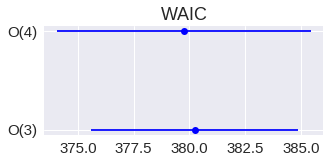

In [37]:
_,ax = pl.subplots(figsize=(5,2))
for i, waic in enumerate((waic_3, waic_4)):
    pl.errorbar(waic[0], i, xerr=waic[1], fmt='bo')
ax.set_title('WAIC')
pl.yticks([0,1],['O(3)','O(4)']);

The WAIC of O(4) is slightly better than O(3) but not significantly so I'll take a quick detour from here and  recast O(3) as a robust model, using a Student T distribution for the likelihood.
***
### Robust O(3) model

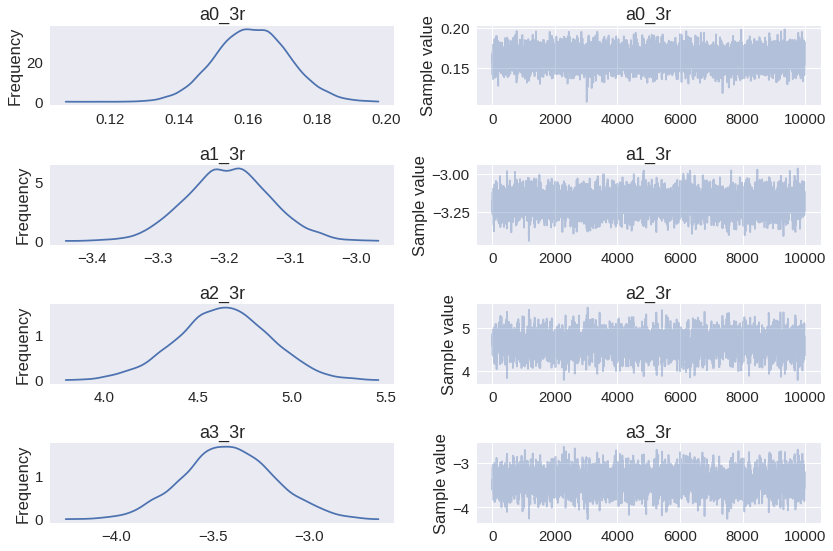

In [38]:
pm.traceplot(trace_ord3_rob,varnames=varnames_o3r);

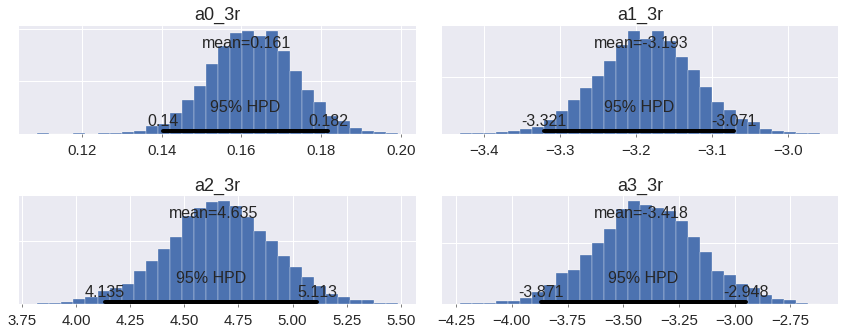

In [39]:
pm.plot_posterior(chain_o3r, varnames=varnames_o3r);
fo3rpp = pl.gcf()
fo3rpp.savefig('./bayesianChl_stuff/o3r_postPlot.png', dpi=300, format='png')

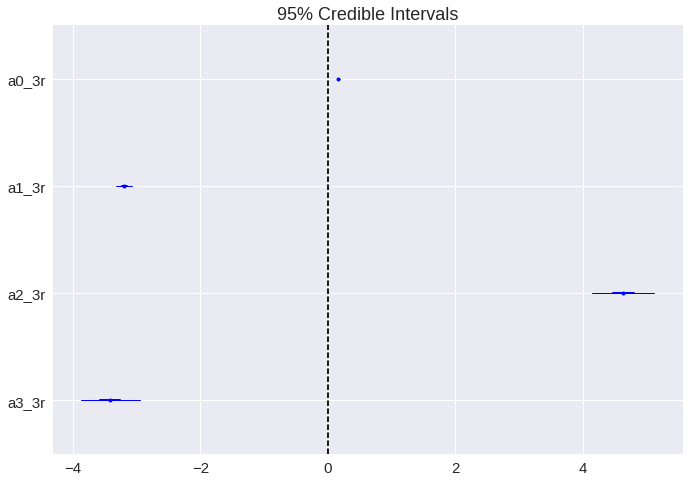

In [40]:
chain_o3r = trace_ord3_rob[1000:]
pm.forestplot(chain_o3r, varnames=['a%d_3r' %i for i in range(4)])
fo3r = pl.gcf()
fo3r.set_size_inches(10,7)
fo3r.savefig('./bayesianChl_stuff/o3r_foresplot.png', dpi=300, format='png')

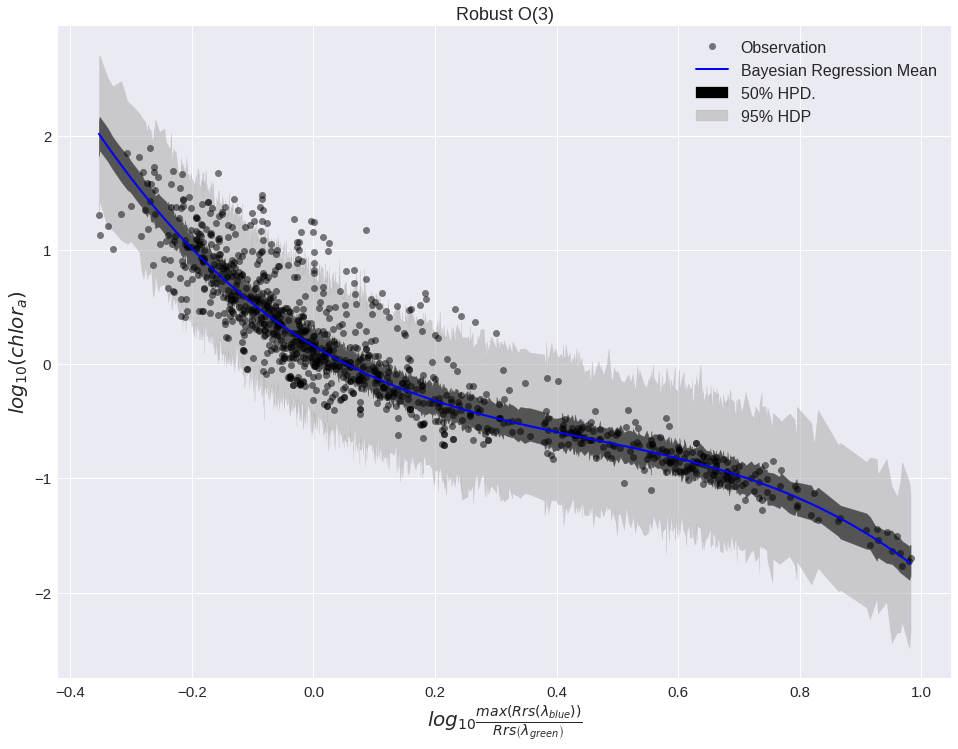

In [42]:
f, ax = pl.subplots(figsize=(16,12))
ax = PlotPPC(X_train, y_train, sig0_ord3r, sig1_ord3r, bayesCoeffs_ord3r,ax=ax, title='Robust O(3)',
            legendOn=False)
idx = np.argsort(X_train)
ax.legend(fontsize=16)
f.savefig('./bayesianChl_stuff/ppcO3O4onO3r.png', dpi=300, format='png')

In [43]:
dic3r = pm.dic(chain_o3r, model=OC4_ord3_robust)

In [44]:
print("DIC, O(4) : %.2f" % dic_4)
print("DIC, O(3) : %.2f" % dic_3)
print("DIC, O(3)R: %.2f" % dic3r)

DIC, O(4) : 419.63
DIC, O(3) : 413.74
DIC, O(3)R: 329.52


In [45]:
waic3r = pm.waic(chain_o3r, model=OC4_ord3_robust, n_eff=True)

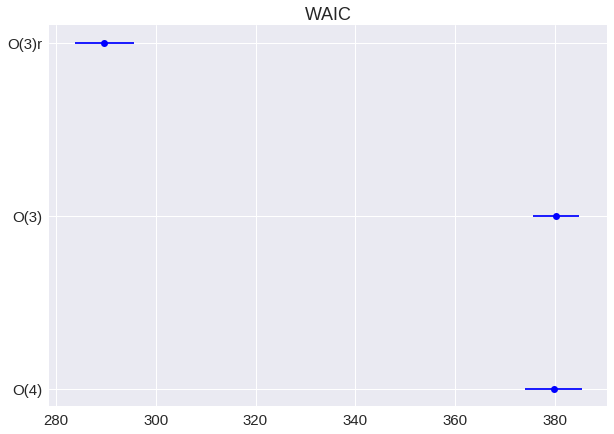

In [46]:
f,ax = pl.subplots(figsize=(10,7))
for i, waic in enumerate((waic_4, waic_3, waic3r)):
    pl.errorbar(waic[0], i, xerr=waic[1], fmt='bo')
ax.set_title('WAIC')
pl.yticks([0,1,2],['O(4)','O(3)','O(3)r']);
f.savefig('./bayesianChl_stuff/waic_o3r_o3_o4.png', dpi=300, format='png')

#### Hierarchical O(3) Robust Model, HO(3)r
The premise here is that there are two methods used to measure chlorophyll; fluorescence and hplc. The latter is admittedly more accurate and more precise. So far I have pooled the data to be modeled. Next, I use a hierarchical model, where hyperparameters allow similarities between data type to be taken into account, and influence the distributions of the parameters corresponding to different chlorophyll measurement method. For this purpose, the DataFrame dfLogOCx has a column, *'chl_type'* that codifies the chl measurement type; 0 is fluorescence, 1 is hplc. I'll take a quick look at the proportion of each type, and then go on to formulating the hierarchical model.

In [47]:
print("# data from fluorescence: %d" %( dfLogOCx.chl_type.size - dfLogOCx.chl_type.sum()))
print("# data from hplc: %d" % dfLogOCx.chl_type.sum())

# data from fluorescence: 599
# data from hplc: 417


The model formulation is more easily understandable visually. Below is the corresponding [Kruschke](http://doingbayesiandataanalysis.blogspot.se/2013/10/diagrams-for-hierarchical-models-we.html) diagram: 

<img src="./bayesianChl_stuff/ocx_h3r.png", width=650, height=600>

In [48]:
numGroups = dfLogOCx.chl_type.unique().size
chl_idx = dfLogOCx.chl_type.values
with pm.Model() as OC4_ho3r:
    # Hyperpriors
    mu_a0 = pm.Normal('mu_a0', mu=0, sd=10)
    sd_a0 = pm.HalfNormal("sd_a0", sd=20)
    mu_a1 = pm.Normal('mu_a1', mu=0, sd=10)
    sd_a1= pm.HalfNormal('sd_a1', sd=20)
    mu_a2 = pm.Normal('mu_a2', mu=0, sd=10)
    sd_a2 = pm.HalfNormal('sd_a2', sd=20)
    mu_a3 = pm.Normal('mu_a3', mu=0, sd=10)
    sd_a3 = pm.HalfNormal("sd_a3", sd=20)
    #Priors
    a0_h3r = pm.Normal('a0_h3r', mu=mu_a0, sd=sd_a0, shape=numGroups)
    a1_h3r = pm.Normal('a1_h3r', mu=mu_a1, sd=sd_a1, shape=numGroups)
    a2_h3r = pm.Normal('a2_h3r', mu=mu_a2, sd=sd_a2, shape=numGroups)
    a3_h3r = pm.Normal('a3_h3r', mu=mu_a3, sd=sd_a3, shape=numGroups)
    # Likelihood
    epsilon_h3r = pm.HalfCauchy('epsilon_h3r', 20)
    mu_h3r =  a0_h3r[chl_idx] + a1_h3r[chl_idx] * X_Shrd + a2_h3r[chl_idx] * X_Shrd**2 + a3_h3r[chl_idx] * X_Shrd**3
    nu_h3r = pm.Deterministic('nu_h3r',pm.Exponential('nu_h3r_', 1/29) + 1)
    chlPred_h3r = pm.StudentT('chlPred_h3r', mu=mu_h3r, sd=epsilon_h3r, nu=nu_h3r, observed=y_train)
    #start = pm.find_MAP()
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=OC4_ho3r.dict_to_array(sds)**2, is_cov=True)
    trace_h3r = pm.sample(10000, step=step, start=mu)
    #step = pm.NUTS(scaling=start)
    #trace_h3r = pm.sample(10000, step=step, start=start)

Applied log-transform to sd_a0 and added transformed sd_a0_log_ to model.
Applied log-transform to sd_a1 and added transformed sd_a1_log_ to model.
Applied log-transform to sd_a2 and added transformed sd_a2_log_ to model.
Applied log-transform to sd_a3 and added transformed sd_a3_log_ to model.
Applied log-transform to epsilon_h3r and added transformed epsilon_h3r_log_ to model.
Applied log-transform to nu_h3r_ and added transformed nu_h3r__log_ to model.


Iteration 0 [0%]: ELBO = -3832.78
Iteration 10000 [10%]: Average ELBO = -2582.23
Iteration 20000 [20%]: Average ELBO = -684.71
Iteration 30000 [30%]: Average ELBO = -305.28
Iteration 40000 [40%]: Average ELBO = -253.22
Iteration 50000 [50%]: Average ELBO = -227.48
Iteration 60000 [60%]: Average ELBO = -209.76
Iteration 70000 [70%]: Average ELBO = -198.54
Iteration 80000 [80%]: Average ELBO = -192.0
Iteration 90000 [90%]: Average ELBO = -187.72
Finished [100%]: Average ELBO = -185.68


100%|██████████| 10000/10000 [07:36<00:00, 32.32it/s]


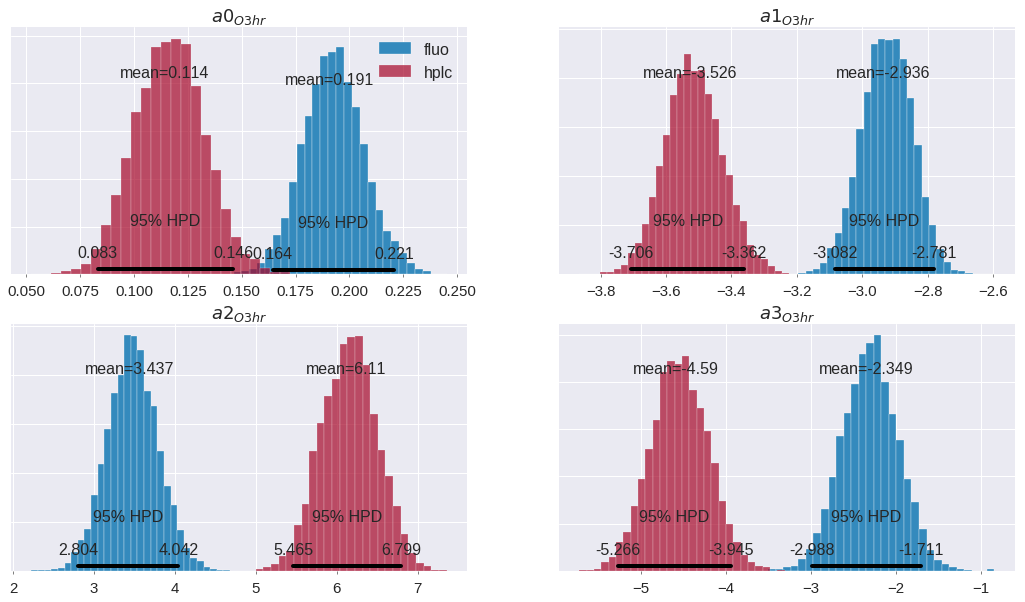

In [49]:
varsH3r = ['a%d_h3r' %i for i in range(4)]
varLbls = ['$a%d_{O3hr}$' % i for i in range(4)]
colors = ["#348ABD", "#A60628"]
f, axs = pl.subplots(nrows=2,ncols=2, figsize=(18, 10))
for i,(ax, var, vlbl) in enumerate(zip(axs.ravel(), varsH3r, varLbls)):
    pm.plot_posterior(trace_h3r[var][1000:, 0], ax=ax, color=colors[0], label='fluo')
    pm.plot_posterior(trace_h3r[var][1000:, 1], ax=ax, color=colors[1],label='hplc', alpha=0.7)
    if i ==0:
        ax.legend(fontsize=16)
    ax.set_title(vlbl, fontsize=18)
f = pl.gcf()
f.savefig('./bayesianChl_stuff/pp_h3r.png', dpi=300, format='png')

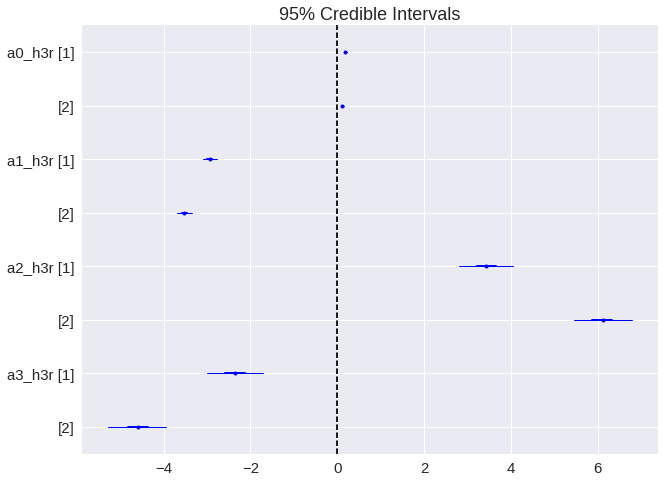

In [50]:
pm.forestplot(trace_h3r, varnames=['a%d_h3r' % i for i in range(4)])
f = pl.gcf()
f.set_size_inches(10,7)
f.savefig('./bayesianChl_stuff/o3hr_forestplot.png', dpi=300, format='png')

In [53]:
dich3r = pm.dic(trace_h3r[1000:], model=OC4_ho3r)
print("DIC, O(4) : %.2f" % dic_4)
print("DIC, O(3) : %.2f" % dic_3)
print("DIC, O(3)R: %.2f" % dic3r)
print("DIC, HO(3)R: %.2f" %dich3r)

DIC, O(4) : 419.63
DIC, O(3) : 413.74
DIC, O(3)R: 329.52
DIC, HO(3)R: 361.65


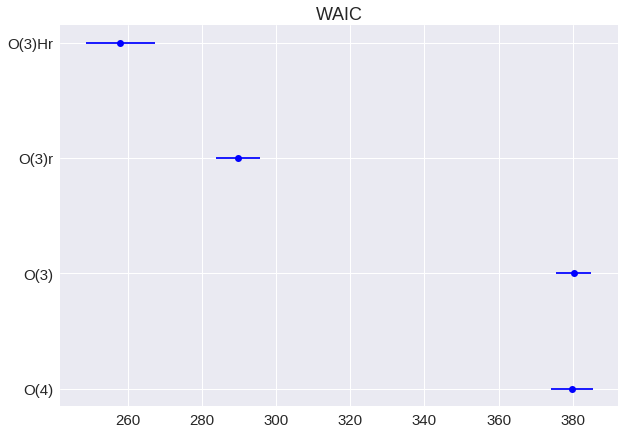

In [55]:
waich3r = pm.waic(trace_h3r[1000:],OC4_ho3r, n_eff=True)

f,ax = pl.subplots(figsize=(10, 7))
for i, waic in enumerate((waic_4, waic_3, waic3r, waich3r)):
    pl.errorbar(waic[0], i, xerr=waic[1], fmt='bo')
ax.set_title('WAIC')
pl.yticks([0,1,2,3],['O(4)','O(3)','O(3)r', 'O(3)Hr']);
f.savefig('./bayesianChl_stuff/waic_ho3r_o3r_o3_o4.png')

Similarly to DIC,  WAIC shows a marked improvement for O(3)r. Since model complexity in this case is no different than that of O(3), it would appears the improvement in both DIC and WAIC come from a better fit to the data. Both O(3)R and HO(3)R score much better in both DIC and WAIC.

### Predicting Outcome from New Data
A machine learning practitioner who what (s)he's doing will want to apply the model to data that has not been used in the fitting process to assess the model's skill in real world predictions. The advantage in this particular case however is that in addition to prediction, we'll get uncertainties, not really available off the shelf with scikit-learn or other machine learning libraries. Even better, we can use the now familiar *posterior predictive checks* approach to do just that. 

As a reminder I framed the input data as a [theano shared variable](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables) to allow replacing the training data with the test data. The test data consists in SeaWiFS matchup data that originates, like NOMAD, from [SeaBASS](https://seabass.gsfc.nasa.gov/). However,  the data in this set was gathered after NOMAD was put together (2010 on) to avoid data leakage.

Another interesting aspect of this particular test data set is that because it's a matchup set it contains corresponding in situ and satellite measurements, which makes for an interesting performance comparison of the model.

In [ ]:
# load test set
dfTest = pd.read_pickle('./bayesianChl_DATA/dfSwfChloraMups2010p.pkl')
dfTest.info()
dfLogTest = pd.DataFrame(columns=['id','seawifs_mxBl2Gr','insitu_chlor_a', 'seawifs_chlor_a'])
dfLogTest.id = dfTest.id
dfLogTest.seawifs_mxBl2Gr=  np.log10(dfTest.seawifs_mxBl2Gr)
dfLogTest.insitu_chlor_a = np.log10(dfTest.insitu_chlor_a)
dfLogTest.seawifs_chlor_a = np.log10(dfTest.seawifs_chlor_a)
X_test, y_test = dfLogTest.seawifs_mxBl2Gr.values, dfLogTest.insitu_chlor_a.values

In [ ]:
dfChain3 = pm.trace_to_dataframe(chain_ord3)
dfChain3['epsilon_3_interval_'] = chain_ord3.get_values(varname='epsilon_3_interval_')
dfChain4 = pm.trace_to_dataframe(chain_ord4)
dfChain4['epsilon_4_interval_'] = chain_ord4.get_values(varname='epsilon_4_interval_')

In [ ]:
# SUBSTITUTING TRAINING SET FOR TEST SET - CHANGING VALUES HERE WILL ALSO CHANGE VALUES IN THE MODEL
X_Shrd.set_value(X_test)
sig0_3Tst, sig1_3Tst = GetPPC(data=X_test, mcChain=chain_ord3, pmModel=OC4_ord3, varname='chlPred_3')
sig0_3RTst, sig1_3RTst = GetPPC(data=X_test, mcChain=chain_o3r, pmModel=OC4_ord3_robust, varname='chlPred_3r')
sig0_4Tst, sig1_4Tst = GetPPC(data=X_test, mcChain=chain_ord4, pmModel=OC4_ord4, varname='chlPred_4')

In [ ]:
bayesCoeffs_3Tst = [chain_ord3['a%d_3' %i].mean() for i in range(4)]
bayesCoeffs_3RTst = [chain_o3r['a%d_3r' %i].mean() for i in range(4)]
bayesCoeffs_4Tst = [chain_ord4['a%d_4' %i].mean() for i in range(5)]

f,axs = pl.subplots(nrows=3, figsize=(8,10),sharex=True)
_ = PlotPPC(X_test, y_test, sig0_4Tst, sig1_4Tst, bayesCoeffs_4Tst, ax=axs[0], title='PPC-Test-O(4)',
            legendOn=False, xlblOn=False)
_ = PlotPPC(X_test, y_test, sig0_3Tst, sig1_3Tst, bayesCoeffs_3Tst, ax=axs[1], title='PPC-Test-O(3)',
           xlblOn=False)
_ = PlotPPC(X_test, y_test, sig0_3RTst, sig1_3RTst, bayesCoeffs_3RTst, ax=axs[2], title='PPC-Test-O(3)R',
           legendOn=False )

Similarly to PPCs on in-sample data, the results of PPC on out-of-sample (test) data confirms that the simpler O(3) polynomial regression does not perform much worse than its more complex O(4) counterpart. From a more frequentist point of view, computing MSEs on frequentist OLS and Bayesian forms of both models shows a slight improvement in favor of the simpler, O(3) version.

In [ ]:
OLS3Mdl= np.poly1d(ols3[::-1]) # encapsulate the fit results into a polynomial object
OLS4Mdl = np.poly1d(ols4[::-1]) 
y_test_pred_ols3 = OLS3Mdl(X_test) # evaluate polynomial with input data
y_test_pred_ols4 = OLS4Mdl(X_test)
y_test_pred_bay3 = 0
y_test_pred_bay3r = 0
y_test_pred_bay4 = 0
for i in range(5):
    y_test_pred_bay4 += chain_ord4['a%d_4' %i].mean()*X_test**i
for i in range(4):
    y_test_pred_bay3 += chain_ord3['a%d_3' %i].mean()*X_test**i
    y_test_pred_bay3r += chain_o3r['a%d_3r' %i].mean()*X_test**i
print("mse, OLS4: %.2f " % mean_squared_error(y_test, y_test_pred_ols4))
print("mse, OLS3: %.2f " % mean_squared_error(y_test, y_test_pred_ols3))
print("mse, Bayes4: %.2f " % mean_squared_error(y_test, y_test_pred_bay4))
print("mse, Bayes3: %.2f " % mean_squared_error(y_test, y_test_pred_bay3))
print("mse, Bayes3R: %.2f" % mean_squared_error(y_test, y_test_pred_bay3r))

# <center>EXPOSE</center>
***

# <center> Empirical Modeling of Chlorophyll </center>
 
## <center> Uncertainty Estimation & The Case for Bayes </center>

 - What:
     * Uncertainty
         * quantification of imperfect information
         * it's here to stay, no choice but to embrace it
    <img src="./bayesianChl_stuff/mcgraynebookcover.jpg" align="right">
 - How:
    * Probabilistic programming
    * Bayes rule, a natural framework for uncertainty estimation
        * used to be controversial - suspicions linger
        * proved itself repeatedly, but often secretly (*cf.* McGrayne) 
        * until recently unfeasible:
            * numerically intractable
            * subject to the curse of dimensionality
         
        * 
 - Why:
    * Scant data not an obstacle
    * Reliance on information to build explanatory/predictive models
    * Uncertainty critical for
        * understanding model weakness(es)
        * curbing enthusiasm around predictions
        * suggesting areas of improvement
    * Inference can be improved through continuous data collection
    * No hypothesis testing against straw man null
        * inference models are pit against eachother 
        * the more probables one are
 - Case study: OC4
    * polynomial regression model 
    * Rrs to chlorophyll *a*

## <center>Road Map</center>
* Bayes Rule: Review/Intro
  
  
* Case study: OC4 (SeaWiFS)
    * Overview
    * Models Development
    * Models Evaluation
    * Decision

## <center> Bayes Rule, a Review </center>

### Bayes' Theorem
$$P(A,B) = P(A|B) \times P(B) = P(B|A) \times P(A)$$
<br>
    
<br>
$$ P(A|B)  = \frac{P(B|A) \times P(A)}{P(B)}$$

### Bayes' Rule & Data Analysis
* D: data, H: hypothesis of interest (e.g. value of a model parameter)
$$ P(H|D) = \frac{P(D|H) \times P(H)}{P(D)}$$

* $P(D|H)$: **Likelihood** of the data given the hypothesis
* $P(H)$: **Prior**, what I know about the hypothesis before seeing the data
* $P(D)$: **Evidence**, probability of the data after marginalizing all hypotheses
    * source of intractability
* $P(H|D)$: **Posterior**, probability of the hypothesis after seeing the data

### Inferring Land Proportion of the Earth

* Start with a prior belief:
    * $P(H)$
    * continuous representation of probability assignment to discrete proportions 
* Collect data:
    * random sampling of locations 
    * land? water?
    * $P(D|H)$
* Update distribution
    * $P(D|H)\times P(H)$

<img src="./bayesianChl_stuff/randomMapPts.png" style="width: 720px;" align="center" />

### Iterative Inference
<br>
<img src="./bayesianChl_stuff/landProp_flat.png" style="width: 720px;" align="left" />
<img src="./bayesianChl_stuff/landProp_weak.png" style="width: 720px;" align="right" />

## <center> OCx Model Overview</center>

* Empirical Polynomial Regression
* Input is blue to green Rrs ratio



$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{4}a_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

## <center> Data Overview </center>
Specific Case: OC4 & SeaWiFS
* blue: 443, 490, 510
* green: 555

## <center>Data Overview</center>

<img src="./bayesianChl_stuff/dataOverview.png" width="70%" align="center">

## <center>Bayesian Regression</center>
### <center>Model 1 - Order 4 Polynomial</center>

$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{4}a_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

## <center>Bayesian Regression</center>
### <center> Model 1 - Order 4 Polynomial</center>
<img src="./bayesianChl_stuff/ocx_34.png" width="60%" alight="center">

<img src="./bayesianChl_stuff/o4_prior.png" width="60%" align="center">

### <center>Turning the Bayesian crank...</center>

### Results :
    O(4) Polynomial Regression
***
<img src="./bayesianChl_stuff/o4_postPlot.png" width="90%" align="center">

### Results :
    O(4) Polynomial Regression
***
<img src="./bayesianChl_stuff/o4_foresplot.png" width="80%" align="center">

### Results :
    O(4) Polynomial Regression
***
<img src="./bayesianChl_stuff/ppcO4.png" width="110%" align="center">

## <center>Bayesian Regression</center>
### <center>Model 2 - Order 3 Polynomial</center>

$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{3}a_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

## <center>Bayesian Regression</center>
### <center> Model 2 - Order 3 Polynomial</center>
<img src="./bayesianChl_stuff/ocx_34.png" width="60%" alight="center">

### Results :
    O(3) Polynomial Regression
***
<img src="./bayesianChl_stuff/o3_postPlot.png" width="90%" align="center">

### Results :
    O(3) Polynomial Regression
***
<img src="./bayesianChl_stuff/ppcO3.png" align="center">

## <center>Bayesian Regression</center>
### <center>Model 3 - Resisting the Outlier's Tug with <u>Robust</u>  O(3) Polynomial Regression</center>

$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{3}a_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

## <center>Bayesian Regression</center>
### <center>Justifying Robust Polynomial Regression</center>
<img src="./bayesianChl_stuff/roblinregjust_1.png" width="90%" alight="center">

## <center>Bayesian Regression</center>
### <center>Justifying Robust Polynomial Regression</center>
<img src="./bayesianChl_stuff/roblinregjust_2.png" width="60%" alight="center">

## <center>Bayesian Regression</center>
### <center>Model 3 - Robust Order 3 Polynomial Regression</center>
<img src="./bayesianChl_stuff/ocx_3r.png" width="70%" alight="center">

### Results :
    O(3) Hierarchical Partial Pooling
***
<img src="./bayesianChl_stuff/o3r_postPlot.png" width="90%" align="center">


a0_3: [0.213, 0.26]         a0_3r: [0.14, 0.182]
a1_3: [-3.124, -2.876]      a1_3r: [-3.321, -3.071]
a2_3: [2.953, 3.959]        a2_3r: [4.135, 5.113]
a3_3: [-3.04, -1.894]       a3_3r: [-3.871, -2.948]

### Results :
    O(3) Robust Polynomial Regression
***
<img src="./bayesianChl_stuff/ppcO3r.png" align="center">

## <center>Bayesian Regression</center>
### <center>Model 4 - Accounting for Differences in Data with Hierarchical Partial Pooling</center>

$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{3}a_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

## <center>Bayesian Regression</center>
### <center>Model 4 - Hierarchical Partial Pooling</center>
<img src="./bayesianChl_stuff/ocx_h3r.png" width="70%" alight="center">

### Results :
    O(3) Hierarchical Partial Pooling
***
<img src="./bayesianChl_stuff/pp_h3r.png" height="150%" align="center">

### Results :
    Hierarchical Partial Pooling
***
**fluo**: [1];
**hplc**: [2]
<img src="./bayesianChl_stuff/o3hr_forestplot.png" width="80%" align="center">

### Model Comparisons:
The diagnostics I will use here are
* posterior predictive checks on in-sample data
* information criteria; including
    * deviance information criterion
    * widely available information criterion
* posterior predictive checks on out-of-sample data

#### Posterior Predictive Checks on in-sample data

***Comparing O(3) and O(3)r PPCs.***

## Last minute addition: Hierarchical Bayes

### Predicting Output from New Data